In [1]:
%load_ext autoreload
%autoreload 2

In [104]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs 

### plotting 
from matplotlib import pyplot as plt
import seaborn as sns

### dask 
from dask.diagnostics import ProgressBar

In [3]:
import dask

### paths 

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### load local libraries 

In [5]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [6]:
sys.path.append('../../') 

In [7]:
from ICU_Water_Watch import geo, C3S, domains, plot, verification

### import libraries for validation

In [8]:
import climpred
from climpred import HindcastEnsemble
import xskillscore as xs

### parameters for papermill 

In [9]:
verif_dset = 'ERA'
quantile = 'quartile'
varname = 'TPRATE'
GCM = 'ECMWF'
period = 'seasonal'
step = 3

## reads the verification dataset 

In [10]:
if verif_dset == 'MSWEP': 
    verif, verif_anomalies = verification.get_mswep()
elif verif_dset == 'CMAP': 
    verif, verif_anomalies = verification.get_cmap()
    verif = verif.drop('ndays')
    verif_anomalies = verif_anomalies.drop('ndays')
elif verif_dset == 'ERA': 
    verif, verif_anomalies = verification.get_era5()

In [11]:
verif = verif.clip(min=0)

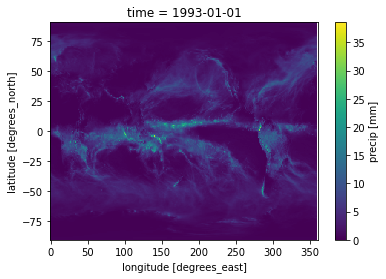

In [12]:
verif['precip'][0,:,:].plot()

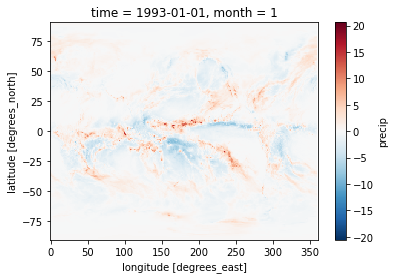

In [13]:
verif_anomalies['precip'][0,:,:].plot()

### we don't need the anomalies, so we close 

In [14]:
verif_anomalies.close()

In [15]:
del(verif_anomalies)

### selects the domain 

In [16]:
domain = domains.domains['Water_Watch']

In [17]:
verif = verif.sel(lat=slice(*domain[2:]), lon=slice(*domain[:2]))

## calculates the seasonal accumulations 

In [18]:
if period == 'seasonal': 
    verif = verif.rolling({'time':3}, min_periods=3).sum('time')
    verif = verif.isel(time=slice(2, None))

### calculates the quantiles 

### first rechunks

In [19]:
verif = verif.chunk({'time':-1, 'lat':10, 'lon':10})

In [20]:
monthly_quantile_climatology_verif = verif.groupby(verif['time'].dt.month).quantile([0.25, 0.5, 0.75], dim='time')

In [21]:
monthly_quantile_climatology_verif

,Array,Chunk
Bytes,2.03 MiB,2.34 kiB
Shape,"(12, 3, 61, 121)","(1, 3, 10, 10)"
Count,15649 Tasks,1092 Chunks
Type,float64,numpy.ndarray


In [22]:
def get_OBS_category_digitize(dset, clim_quantiles, varname='precip', dim='quantile'): 
    import numpy as np 
    import xarray as xr
    try: 
        import dask 
    except ImportError("dask is not available ..."):
        pass 
    
    def _digitize(x, bins):
        return np.digitize(x.ravel(), bins.ravel())
    
    categories = xr.apply_ufunc(_digitize, dset[varname], clim_quantiles[varname], input_core_dims=[[], [dim]],
                vectorize=True, dask='parallelized')
    
    # add one so that the categories go from 1 to N_categories + 1 
    categories += 1
    
    return categories

In [23]:
verif_quantile_categories = []

for date in verif.time:
    
    x = verif.sel(time=date)
    
    month = date.dt.month.data
    
    clim_quantile = monthly_quantile_climatology_verif.sel(month=month)
    
    quantile_category = get_OBS_category_digitize(x, clim_quantile, varname='precip', dim='quantile')
    
    quantile_category = quantile_category.expand_dims({'time':[date.data]})
    
    verif_quantile_categories.append(quantile_category)

In [24]:
verif_quantile_categories = xr.concat(verif_quantile_categories, dim='time')

In [25]:
verif_quantile_categories = verif_quantile_categories.to_dataset(name='precip')

In [26]:
verif_quantile_categories

,Array,Chunk
Bytes,16.11 MiB,800 B
Shape,"(286, 61, 121)","(1, 10, 10)"
Count,200015 Tasks,26026 Chunks
Type,int64,numpy.ndarray


### Now read the tercile categories from the GCM 

In [27]:
GCMs = ['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP', 'JMA']

In [28]:
dpath_gcm = pathlib.Path(f"/media/nicolasf/END19101/ICU/data/CDS/{GCM}/{quantile}_probs/{varname}") 

In [29]:
lfiles = list(dpath_gcm.glob("*.netcdf"))

In [30]:
lfiles.sort()

In [31]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/ECMWF/quartile_probs/TPRATE/ECMWF_seasonal_quartiles_probs_1993-01.netcdf')

In [32]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/ECMWF/quartile_probs/TPRATE/ECMWF_seasonal_quartiles_probs_2016-12.netcdf')

In [33]:
dset_gcm = xr.open_mfdataset(lfiles, parallel=True, engine='netcdf4')

In [34]:
dset_gcm

,Array,Chunk
Bytes,258.42 MiB,918.84 kiB
Shape,"(288, 4, 3, 81, 121)","(1, 4, 3, 81, 121)"
Count,864 Tasks,288 Chunks
Type,float64,numpy.ndarray


### take the leadtime in the GCM

In [35]:
dset_gcm_m = dset_gcm.sel(step=step)

In [36]:
dset_gcm_m['time'] = dset_gcm_m.indexes['time'] + pd.offsets.MonthBegin(step)

In [37]:
dset_gcm_m

,Array,Chunk
Bytes,86.14 MiB,306.28 kiB
Shape,"(288, 4, 81, 121)","(1, 4, 81, 121)"
Count,1152 Tasks,288 Chunks
Type,float64,numpy.ndarray


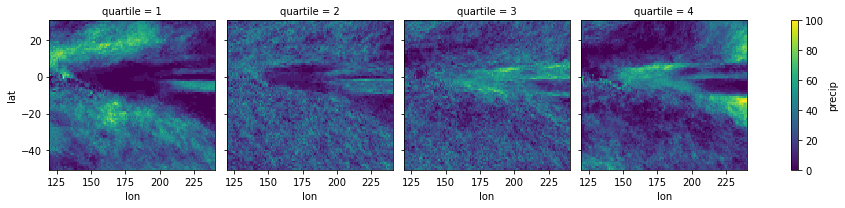

In [38]:
dset_gcm_m['precip'].isel(time=0).plot(x='lon', y='lat', col=quantile)

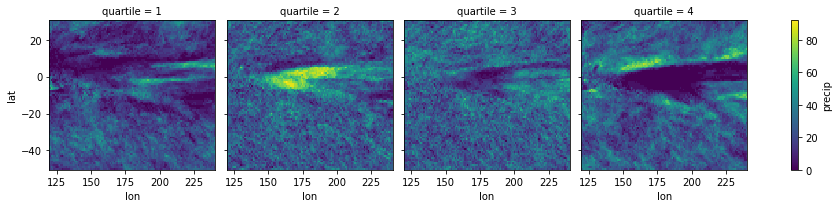

In [39]:
dset_gcm_m['precip'].isel(time=-1).plot(x='lon', y='lat', col=quantile)

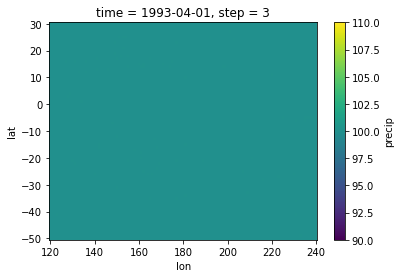

In [40]:
dset_gcm_m.sum(quantile).isel(time=0)['precip'].plot()

### most likely quartile 

In [44]:
dset_gcm_m = dset_gcm_m.idxmax(dim=quantile)

KeyError: 'Dimension "quartile" not in dimension'

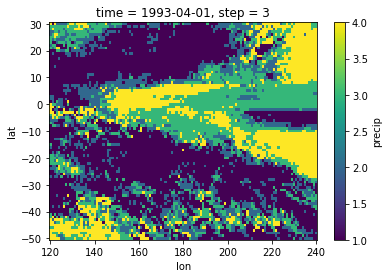

In [45]:
dset_gcm_m['precip'][0,:,:].plot()

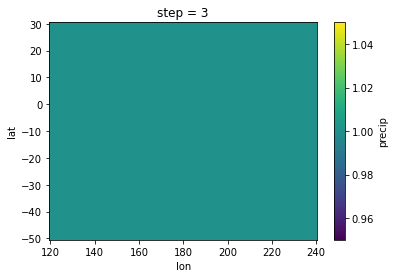

In [46]:
dset_gcm_m.min('time')['precip'].plot()

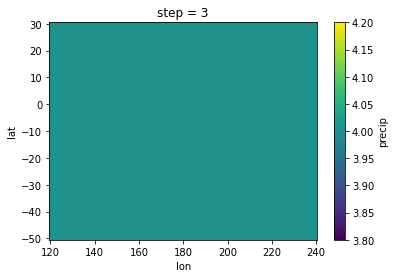

In [47]:
dset_gcm_m.max('time')['precip'].plot()

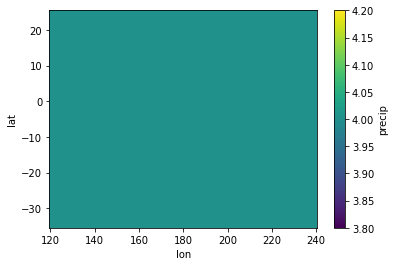

In [48]:
verif_quantile_categories.max('time')['precip'].plot()

In [49]:
verif_quantile_categories

,Array,Chunk
Bytes,16.11 MiB,800 B
Shape,"(286, 61, 121)","(1, 10, 10)"
Count,200015 Tasks,26026 Chunks
Type,int64,numpy.ndarray


In [50]:
accuracy = verif_quantile_categories == dset_gcm_m

In [51]:
acc_month = accuracy.sel(time=accuracy.time.dt.month == 10)

In [52]:
acc_month = acc_month.sum('time') / len(acc_month.time)

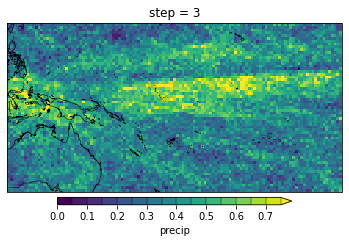

In [53]:
fg = acc_month['precip'].plot(x='lon',y='lat', levels=np.arange(0, 0.8, 0.05), \
                     subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},\
                      transform=ccrs.PlateCarree(),\
                      cmap=plt.cm.viridis,\
                     cbar_kwargs={'shrink':0.7, 'orientation':'horizontal', 'pad':0.025, 'aspect':30, 'drawedges':True})
fg.axes.coastlines(resolution='10m', lw=0.5)

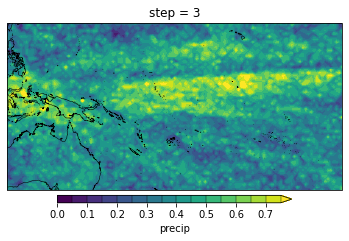

In [55]:
fg = acc_month['precip'].plot.contourf(x='lon',y='lat', levels=np.arange(0, 0.8, 0.05), \
                     subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},\
                      transform=ccrs.PlateCarree(),\
                      cmap=plt.cm.viridis,\
                     cbar_kwargs={'shrink':0.7, 'orientation':'horizontal', 'pad':0.025, 'aspect':30, 'drawedges':True})
fg.axes.coastlines(resolution='10m', lw=0.5)

In [56]:
map_accuracy = accuracy.sum('time') / len(accuracy.time)

In [57]:
map_accuracy = map_accuracy.compute().load()

In [58]:
map_accuracy = map_accuracy.where(map_accuracy['precip'] >= 0.25) 

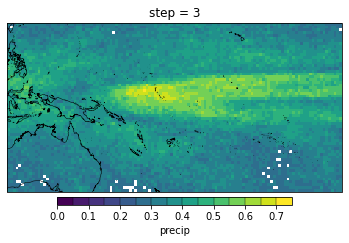

In [59]:
fg = map_accuracy['precip'].plot(x='lon',y='lat', levels=np.arange(0, 0.8, 0.05), \
                     subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},\
                      transform=ccrs.PlateCarree(),\
                      cmap=plt.cm.viridis,\
                     cbar_kwargs={'shrink':0.7, 'orientation':'horizontal', 'pad':0.025, 'aspect':30, 'drawedges':True})
fg.axes.coastlines(resolution='10m', lw=0.5)

In [61]:
g_verif = verif_quantile_categories.sel(lat=0, lon=180)

In [62]:
g_gcm = dset_gcm_m.sel(lat=0, lon=180)

In [65]:
g_verif = g_verif['precip'].to_pandas()

In [66]:
g_gcm = g_gcm['precip'].to_pandas()

<AxesSubplot:xlabel='time'>

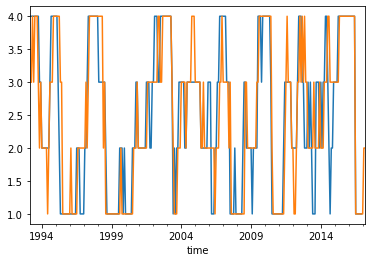

In [69]:
f, ax = plt.subplots()
g_verif.plot(ax=ax)
g_gcm.plot(ax=ax)

In [70]:
df_g = pd.concat([g_gcm, g_verif], axis=1)

In [74]:
df_g = df_g.dropna(axis=0)

In [75]:
df_g.columns = ['gcm', 'verif']

In [79]:
(df_g.gcm == df_g.verif ).sum() / len(df_g)

0.624561403508772

### selects the observations for which the verification dataset is below the 25th percentile 

In [82]:
ess = df_g.query("verif == 1")

### true positives 

In [84]:
(ess.gcm == ess.verif ).sum() / len(ess)

0.75

### false negatives 

In [85]:
(ess.gcm != ess.verif ).sum() / len(ess)

0.25

In [86]:
ess = df_g.query("gcm == 1")

In [87]:
(ess.gcm == ess.verif ).sum() / len(ess)

0.7714285714285715

In [88]:
(ess.gcm != ess.verif ).sum() / len(ess)

0.22857142857142856

In [89]:
verif_quantile_categories

,Array,Chunk
Bytes,16.11 MiB,800 B
Shape,"(286, 61, 121)","(1, 10, 10)"
Count,200015 Tasks,26026 Chunks
Type,int64,numpy.ndarray


In [91]:
dset_gcm_m, verif_quantile_categories = xr.align(dset_gcm_m, verif_quantile_categories)

In [95]:
dset_merge = dset_gcm_m.rename_vars({'precip':'gcm'}).merge(verif_quantile_categories.rename_vars({'precip':'verif'}))

In [96]:
dset_merge

<xarray.Dataset>
Dimensions:  (time: 285, lat: 61, lon: 121)
Coordinates:
  * time     (time) datetime64[ns] 1993-04-01 1993-05-01 ... 2016-12-01
  * lat      (lat) float64 -35.0 -34.0 -33.0 -32.0 -31.0 ... 22.0 23.0 24.0 25.0
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
    step     int64 3
    month    (time) int64 4 5 6 7 8 9 10 11 12 1 2 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    gcm      (time, lat, lon) float64 dask.array<chunksize=(1, 61, 121), meta=np.ndarray>
    verif    (time, lat, lon) int64 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>

### rechunk 

In [98]:
dset_merge = dset_merge.chunk({'time':-1, 'lat':10, 'lon':10},)

In [126]:
dset_merge.nbytes / 1e9

0.0336629

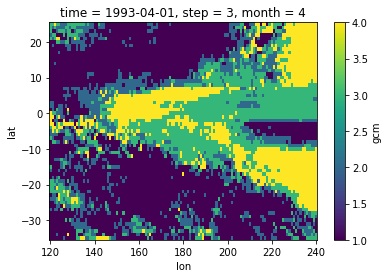

In [100]:
dset_merge['gcm'][0,:,:].plot()

In [106]:
with ProgressBar(): 
    dset_merge = dset_merge.compute()

[########################################] | 100% Completed |  1min 17.5s


### True Positives: predicted class 1 == observed class 1

In [146]:
TP = (dset_merge.where(dset_merge['verif'] == 1).where(dset_merge['gcm'] == 1)).sum('time')

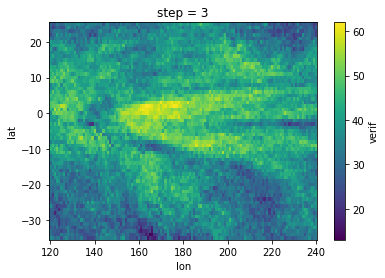

In [147]:
TP['verif'].plot()

### True Negatives 

In [ ]:
TN = dset_merge.where(dset_merge['verif'] != 1 and 

In [148]:
TN = (dset_merge.where(dset_merge['verif'] != 1).where(dset_merge['gcm'] != 1)).sum('time')

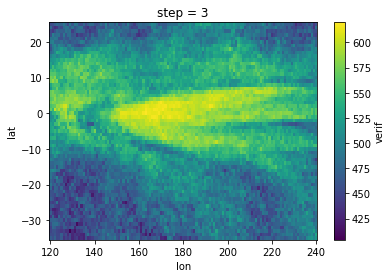

In [149]:
TN['verif'].plot()

### False positives 

In [138]:
FP = dset_merge.where(dset_merge['verif'] != 1).where(dset_merge['gcm'] == 1).sum('time')

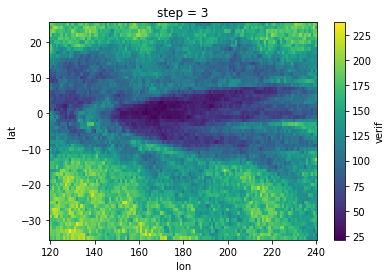

In [139]:
FP['verif'].plot()

### False Negatives 

In [140]:
FN = dset_merge.where(dset_merge['verif'] == 1).where(dset_merge['gcm'] != 1).sum('time')

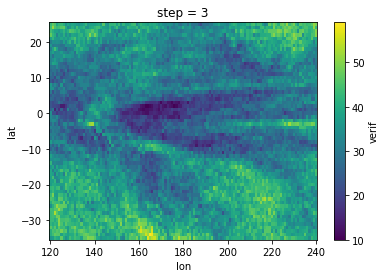

In [141]:
FN['verif'].plot()

In [142]:
acc = (TP+TN)/(TP+FP+FN+TN) 

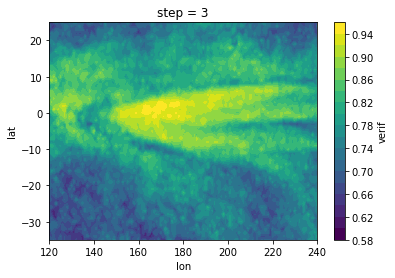

In [145]:
acc['verif'].plot.contourf(levels=20)

In [124]:
ess = dset_merge.where(dset_merge['verif'] == 1).where(dset_merge['gcm'] == 1).sum('time') / \
(dset_merge['gcm'].where(dset_merge['gcm'] == 1).sum('time') + dset_merge['verif'].where(dset_merge['verif'] == 1).sum('time'))

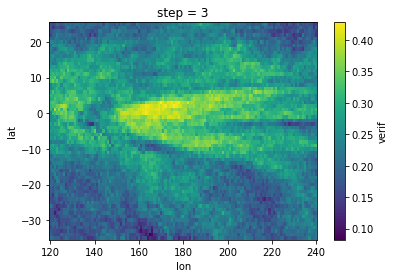

In [125]:
ess['verif'].plot()

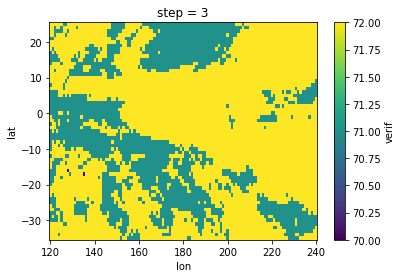

In [116]:
dset_merge['verif'].where(dset_merge['verif'] == 1).sum('time')

### accuracy 

In [ ]:
accuracy = verif_quantile_categories == dset_gcm_m

In [ ]:
fg = map_accuracy['precip'].plot.contourf(x='lon',y='lat', levels=np.arange(0.3, 0.8, 0.05), \
                     subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},\
                      transform=ccrs.PlateCarree(),\
                      cmap=plt.cm.viridis,\
                     cbar_kwargs={'shrink':0.7, 'orientation':'horizontal', 'pad':0.025, 'aspect':30, 'drawedges':True})
fg.axes.coastlines(resolution='10m', lw=0.5)
fg.axes.set_extent([140, 240, -25, 25])

In [ ]:
verif_tercile_categories, dset_gcm_m = xr.align(verif_tercile_categories, dset_gcm_m)

In [ ]:
nino = verification.get_CPC_NINO()

In [ ]:
nino = nino.loc['1993':'2016',:]

In [ ]:
el_nino = nino.loc[nino.loc[:,'NINO3.4'] >= 0.7,:]

In [ ]:
la_nina = nino.loc[nino.loc[:,'NINO3.4'] <= -0.7,:]

In [ ]:
neutral = nino.loc[(nino.loc[:,'NINO3.4'] > -0.7) & (nino.loc[:,'NINO3.4'] < 0.7),:]

In [ ]:
neutral

In [ ]:
xs_table = xs.Contingency(verif_tercile_categories.sel(time=neutral.index[1:]), dset_gcm_m.sel(time=neutral.index[1:]), np.array([1,2,3,4]), np.array([1,2,3,4]), dim='time')

In [ ]:
xs_table

In [ ]:
acc_xs = xs_table.accuracy()

In [ ]:
acc_xs = acc_xs.compute()

In [ ]:
fg = acc_xs['precip'].plot.contourf(x='lon',y='lat', levels=np.arange(0.2, 0.8, 0.05), \
                     subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},\
                      transform=ccrs.PlateCarree(),\
                      cmap=plt.cm.viridis,\
                     cbar_kwargs={'shrink':0.7, 'orientation':'horizontal', 'pad':0.025, 'aspect':30, 'drawedges':True})
fg.axes.coastlines(resolution='10m', lw=0.5)
# fg.cbar.set_label("accuracy [0-1]")

# acc_xs['precip'].plot.contour(x='lon', y='lat', levels=[ 0.5], colors='w', transform=ccrs.PlateCarree())
plt.gcf().savefig(f"./{GCM}_accuracy_Neutral.png", dpi=200, bbox_inches='tight', facecolor='w')

In [ ]:
heidke_xs = xs_table.heidke_score()

In [ ]:
heidke_xs = heidke_xs.compute()

In [ ]:
heidke_xs['precip'].plot()

In [ ]:
fg = heidke_xs['precip'].plot.contourf(x='lon',y='lat', levels=np.arange(-1, 1.1, 0.1), \
                     subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},\
                      transform=ccrs.PlateCarree(),\
                      cmap=plt.cm.RdBu_r,\
                     cbar_kwargs={'shrink':0.7, 'orientation':'horizontal', 'pad':0.025, 'aspect':30, 'drawedges':True})
fg.axes.coastlines(resolution='10m', lw=0.5)
# fg.cbar.set_label("accuracy [0-1]")

# acc_xs['precip'].plot.contour(x='lon', y='lat', levels=[ 0.5], colors='w', transform=ccrs.PlateCarree())